In [1]:
#from dask.distributed import Client, LocalCluster
import os
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

import netCDF4 as nc
from datetime import datetime
import xarray as xr

from datacube.api import GridWorkflow
from datacube.drivers.netcdf import write_dataset_to_netcdf
from datacube.storage import masking


from madmex.wrappers import gwf_query
from madmex.util import join_dicts
from madmex.util import mid_date
from madmex.util.xarray import to_float, to_int
from madmex.util import mid_date



In [2]:
product = ['ls5_espa_mexico']
begin = '1995-01-01'
end = '1996-12-31'
region = 'Durango'
gwf_kwargs = {'region': region, 'begin': begin, 'end': end}
dict_list=[]

In [3]:
for prod in product:
    gwf_kwargs.update(product = prod)
    try:
        dict_list.append(gwf_query(**gwf_kwargs, view=False))
    # Exception is in case one of the product hasn't been registered in the datacube
    except Exception as e:
        pass


In [4]:
iterable = join_dicts(*dict_list, join='full').items()

In [5]:
lista_iter = list(iterable)

In [6]:
len(lista_iter)

20

In [7]:
list_iterable_sorted = sorted(lista_iter, key=itemgetter(0))

In [8]:
recipe_reference = 'recipe_mex_L7L8_1415'
begin = '2014-01-01'
end = '2015-12-31'
region = 'Durango'
gwf_kwargs_reference = {'product': recipe_reference, 'region': region,  'begin': begin, 'end': end}


In [9]:
iterable_reference = gwf_query(**gwf_kwargs_reference)

In [10]:
list_iterable_reference = list(iterable_reference)

In [11]:
len(list_iterable_reference)

20

In [12]:
list_iterable_reference_sorted = sorted(list_iterable_reference, key=itemgetter(0))

In [13]:
list_iterable_reference_sorted[0]

((19, -20), Tile<sources=<xarray.DataArray (time: 1)>
 array([(Dataset <id=32f55915-c931-5e49-b027-794a59a94ed6 type=recipe_mex_L7L8_1415 location=file://shared_volume/datacube/datacube_ingest/recipes/recipe_mex_L7L8_1415/madmex_003_19_-20_2014-12-31.nc>,)],
       dtype=object)
 Coordinates:
   * time     (time) datetime64[ns] 2014-12-31T12:00:00,
 	geobox=GeoBox(1667, 1667, Affine(30.0, 0.0, 1927350.0,
        0.0, -30.0, 1476530.0), PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",SPHEROID["WGS84",6378137,6556752.3141]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["standard_parallel_1",17.5],PARAMETER["standard_parallel_2",29.5],PARAMETER["latitude_of_origin",12],PARAMETER["central_meridian",-102],PARAMETER["false_easting",2500000],PARAMETER["false_northing",0]])>)

In [14]:
list_iterable_reference_sorted[0][0]

(19, -20)

In [15]:
list_dc_tiles_reference = [k[0] for k in list_iterable_reference_sorted]


def search_tile_in_reference(dc_tile):
    a = [tile for tile in list_iterable_reference_sorted if tile[0] == dc_tile]
    return a[0]

In [16]:
list_iterable_reference_adjusted = [tile if tile[0] not in list_dc_tiles_reference else search_tile_in_reference(tile[0]) for tile in list_iterable_sorted]

In [17]:
len(list_iterable_reference_adjusted)

20

In [18]:
list_union = [(s,t) for (s,t) in zip(list_iterable_sorted, list_iterable_reference_adjusted)]

# Usando sólo una entrada de las listas de iterables construídas previamente

In [19]:
list_union_one_entry = [(list_iterable_sorted[3],list_iterable_reference_adjusted[3])]

In [20]:
list_union_one_entry

[(((20, -19), [Tile<sources=<xarray.DataArray (time: 7)>
    array([(Dataset <id=b0168522-b02b-49ba-83b3-0cb22c203105 type=ls5_espa_mexico location=file:///shared_volume/datacube/datacube_ingest/LS5_espa/mexico/LS5_espa_20_-19_19950206164648000000.nc>,),
           (Dataset <id=a57d0c95-235f-4ae0-a5cf-2e8eb2318a12 type=ls5_espa_mexico location=file:///shared_volume/datacube/datacube_ingest/LS5_espa/mexico/LS5_espa_20_-19_19950310164531000000.nc>,),
           (Dataset <id=a63b4299-32cf-4e3b-a09b-36e27bc467c8 type=ls5_espa_mexico location=file:///shared_volume/datacube/datacube_ingest/LS5_espa/mexico/LS5_espa_20_-19_19951121163445000000.nc>,),
           (Dataset <id=941f5dbb-5031-4b02-9813-41bcfb2cb8a9 type=ls5_espa_mexico location=file:///shared_volume/datacube/datacube_ingest/LS5_espa/mexico/LS5_espa_20_-19_19960124163902000000.nc>,),
           (Dataset <id=f0a72436-d187-4d98-9918-c7974176f8bd type=ls5_espa_mexico location=file:///shared_volume/datacube/datacube_ingest/LS5_espa/mexi

In [25]:
begin=(datetime.strptime(begin, '%Y-%m-%d'))
end = datetime.strptime(end,'%Y-%m-%d')
center_dt = mid_date(begin,end)

In [26]:
def hist_match_and_plot_old(source2D, reference2D):
    orig_shape = source2D.shape
    s_values, s_idx, s_counts = np.unique(source2D, return_inverse=True, return_counts=True)
    r_values, r_counts = np.unique(reference2D, return_counts=True)
    s_quantiles = np.cumsum(s_counts).astype(np.float64) / source2D.size
    r_quantiles = np.cumsum(r_counts).astype(np.float64) / reference2D.size
    #interp_r_values = np.interp(s_quantiles, r_quantiles, r_values)
    #target = interp_r_values[s_idx].reshape(orig_shape)
    #t_values, t_counts = np.unique(target, return_counts=True)
    #t_quantiles = np.cumsum(t_counts).astype(np.float64) / target.size
    plt.plot(s_values, s_quantiles,'--b',label="Source")
    plt.plot(r_values, r_quantiles, label="Reference")
    #plt.plot(t_values, t_quantiles, '--r', lw=2, label="Target")
    plt.title('second group of plots')
    plt.legend(loc=5)
    plt.show()
    #return target

In [36]:
def fun(tile, center_dt, path, histogram_match=False):
    if histogram_match:
        print('beginning hist match')
        tile_reference = tile[1]
        tile = tile[0]
    # Get crs from first tile of tile list
    crs = tile[1][0].geobox.crs
    center_dt = center_dt.strftime("%Y-%m-%d")
    if histogram_match:
        nc_filename = os.path.join(path, 'madmex_004_%d_%d_%s_matching_histograms.nc' % (tile[0][0], tile[0][1], center_dt))
    else:
        nc_filename = os.path.join(path, 'madmex_004_%d_%d_%s.nc' % (tile[0][0], tile[0][1], center_dt))
    # Load Landsat sr
    if os.path.isfile(nc_filename):
        logger.warning('%s already exists. Returning filename for database indexing', nc_filename)
        return nc_filename
    sr_0 = xr.auto_combine([GridWorkflow.load(x, dask_chunks={'x': 1200, 'y': 1200})
                     for x in tile[1]], concat_dim='time')
    sr_0.attrs['geobox'] = tile[1][0].geobox
    sr_0.attrs['crs'] = crs
    # Mask clouds, shadow, water, ice,... and drop qa layer
    clear = masking.make_mask(sr_0.pixel_qa, cloud=False, cloud_shadow=False,
                              snow=False)
    sr_1 = sr_0.where(clear)
    sr_1 = sr_1.drop('pixel_qa')
    sr_1 = sr_1.apply(func=to_float, keep_attrs=True)
    def nan_helper(y):
        return np.isnan(y), lambda z: z.nonzero()[0]
    # Check wheter or not to perform histogram matching:
    if histogram_match:
        def histogram_matching(source2D_band, r_values, r_quantiles):
            orig_shape = source2D_band.shape
            idx_nans = np.isnan(source2D_band)
            source_ravel = source2D_band.ravel()
            nans, x= nan_helper(source_ravel)
            source_ravel[nans]= np.interp(x(nans), x(~nans), source_ravel[~nans])
            source2D_band = source_ravel.reshape(orig_shape)      
            s_values, s_idx, s_counts = np.unique(source2D_band, return_inverse=True, return_counts=True)
            s_quantiles = np.cumsum(s_counts).astype(np.float64) / source2D_band.size
            interp_r_values = np.interp(s_quantiles, r_quantiles, r_values)
            target = interp_r_values[s_idx].reshape(orig_shape)
            #plot, just checking....
            t_values, t_counts = np.unique(target, return_counts=True)
            t_quantiles = np.cumsum(t_counts).astype(np.float64) / target.size
            plt.plot(r_values, r_quantiles, label="Reference")
            plt.plot(t_values, t_quantiles, '--r', lw=2, label="Target")
            plt.title('first group of plots')
            plt.show()
            #end plot, just checking...
            target[idx_nans] = -9999
            return target
        def wrapper_histogram_match(source2D_band, reference2D_band, n_times):
            r_values, r_counts = np.unique(reference2D_band, return_counts=True)
            r_quantiles = np.cumsum(r_counts).astype(np.float64) / reference2D_band.size
            target_DA = xr.concat([xr.DataArray(histogram_matching(source2D_band.isel(time=k).values,
                                                                               r_values,
                                                                               r_quantiles),
                                                dims=['y','x'],
                                                coords= {'y': source2D_band.coords['y'],
                                                         'x': source2D_band.coords['x'],
                                                         'time': source2D_band.coords['time'][k]},
                                                attrs=source2D_band.attrs) for k in range(0,n_times)],dim='time')
            return target_DA

        try:
            sr_reference = GridWorkflow.load(tile_reference[1],
                                             dask_chunks={'x': 1200, 'y': 1200},
                                             measurements=['blue_mean',
                                                           'green_mean',
                                                           'red_mean',
                                                           'nir_mean',
                                                           'swir1_mean',
                                                           'swir2_mean'])
            xr_ds = xr.Dataset({}, attrs = sr_1.attrs)
            band_list_source = list(sr_1.data_vars)
            for band in band_list_source:
                xr_ds[band] = wrapper_histogram_match(sr_1[band],
                                                      sr_reference[band + '_mean'].values,
                                                      sr_1.dims['time'])
            sr_1.update(xr_ds.chunk({'x': 1200, 'y': 1200}))
            sr_1 = sr_1.where(clear)
            sr_1 = sr_1.apply(func=to_float, keep_attrs=True)
            xr_ds = None
            hist_match_and_plot_old(sr_1.blue.isel(time=3).values, sr_reference.blue_mean.values)
            hist_match_and_plot_old(sr_1.swir2.isel(time=5).values, sr_reference.swir2_mean.values)
            
        except Exception as e:
            print(e)
    # Compute vegetation indices
    sr_1['ndvi'] = ((sr_1.nir - sr_1.red) / (sr_1.nir + sr_1.red)) * 10000
    sr_1['ndvi'].attrs['nodata'] = -9999
    sr_1['ndmi'] = ((sr_1.nir - sr_1.swir1) / (sr_1.nir + sr_1.swir1)) * 10000
    sr_1['ndmi'].attrs['nodata'] = -9999
    # Run temporal reductions and rename DataArrays
    sr_mean = sr_1.mean('time', keep_attrs=True, skipna=True)
    sr_mean.rename({'blue': 'blue_mean',
                    'green': 'green_mean',
                    'red': 'red_mean',
                    'nir': 'nir_mean',
                    'swir1': 'swir1_mean',
                    'swir2': 'swir2_mean',
                    'ndmi': 'ndmi_mean',
                    'ndvi': 'ndvi_mean'}, inplace=True)
    # Compute min/max/std only for vegetation indices
    ndvi_max = sr_1.ndvi.max('time', keep_attrs=True, skipna=True)
    ndvi_max = ndvi_max.rename('ndvi_max')
    ndvi_max.attrs['nodata'] = -9999
    ndvi_min = sr_1.ndvi.min('time', keep_attrs=True, skipna=True)
    ndvi_min = ndvi_min.rename('ndvi_min')
    ndvi_min.attrs['nodata'] = -9999
    # ndmi
    ndmi_max = sr_1.ndmi.max('time', keep_attrs=True, skipna=True)
    ndmi_max = ndmi_max.rename('ndmi_max')
    ndmi_max.attrs['nodata'] = -9999
    ndmi_min = sr_1.ndmi.min('time', keep_attrs=True, skipna=True)
    ndmi_min = ndmi_min.rename('ndmi_min')
    ndmi_min.attrs['nodata'] = -9999
    # Load terrain metrics using same spatial parameters than sr
    #dc = datacube.Datacube(app = 'landsat_madmex_002_%s' % randomword(5))
    #terrain = dc.load(product='srtm_cgiar_mexico', like=sr_0,
    #                  time=(datetime(1970, 1, 1), datetime(2018, 1, 1)),
    #                  dask_chunks={'x': 1200, 'y': 1200})
    #dc.close()
    # Merge dataarrays
    combined = xr.merge([sr_mean.apply(to_int),
                         to_int(ndvi_max),
                         to_int(ndvi_min),
                         to_int(ndmi_max),
                         to_int(ndmi_min)])
    #                     terrain])
    combined.attrs['crs'] = crs
    combined = combined.compute(scheduler='threads')
    #
    write_dataset_to_netcdf(combined, nc_filename)
    # Explicitely deallocate objects and run garbage collector
    #sr_0=sr_1=sr_mean=clear=ndvi_max=ndvi_min=ndmi_max=ndmi_min=terrain=combined=None
    sr_0=sr_1=sr_mean=clear=ndvi_max=ndvi_min=ndmi_max=ndmi_min=combined=None
    gc.collect()
    return combined

In [37]:
path='/shared_volume/temp/'

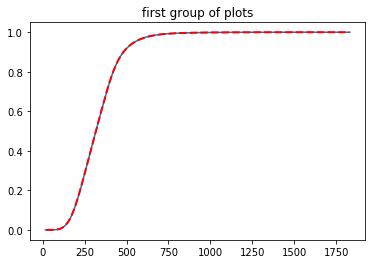

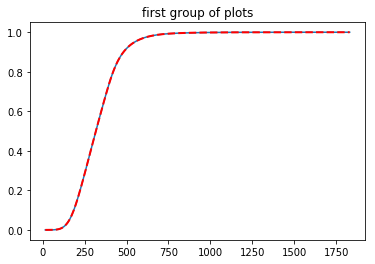

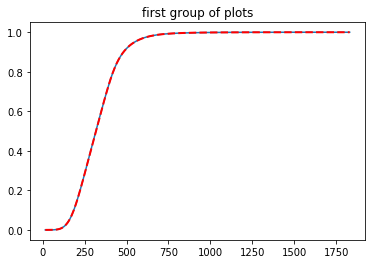

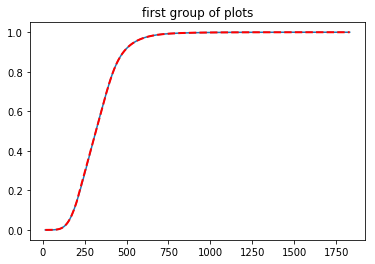

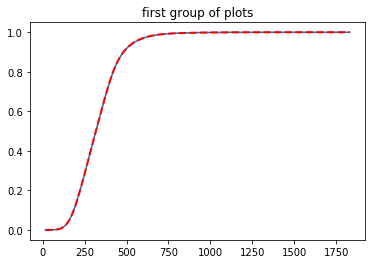

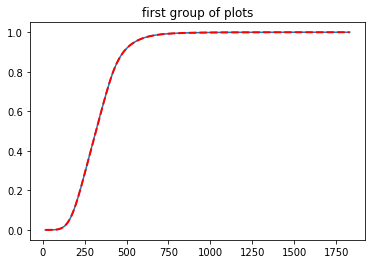

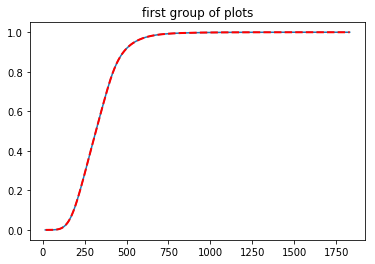

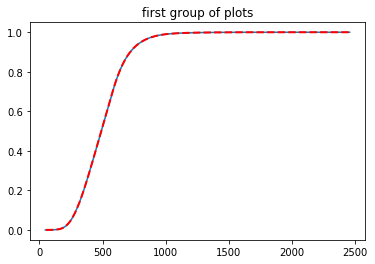

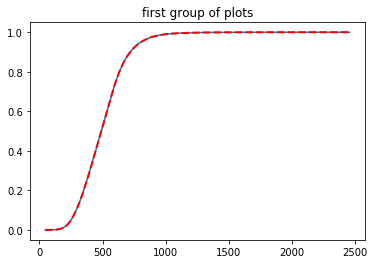

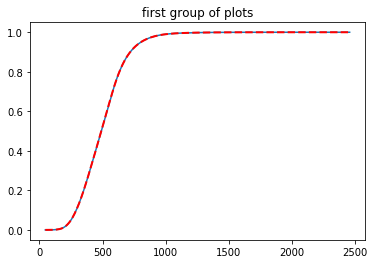

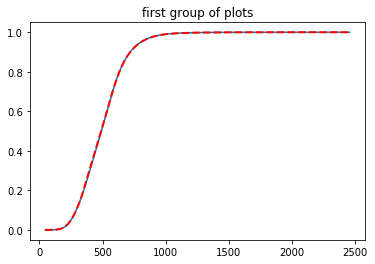

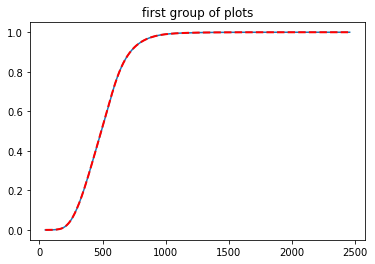

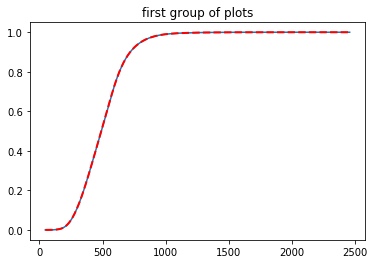

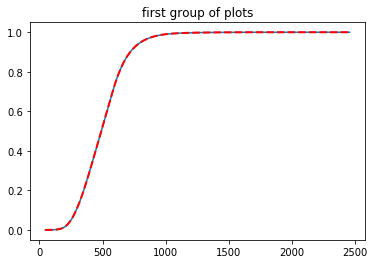

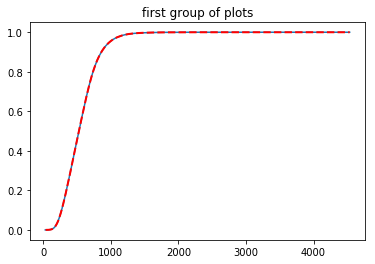

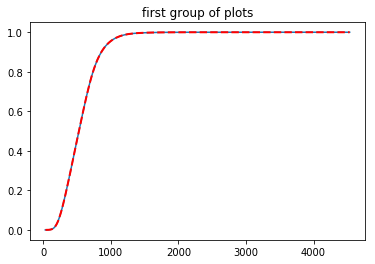

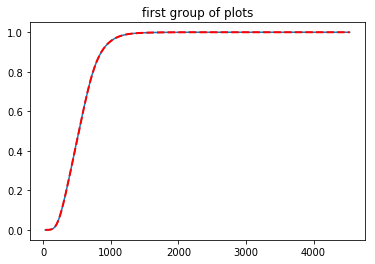

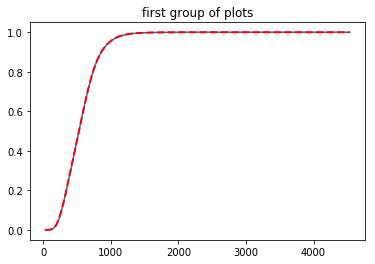

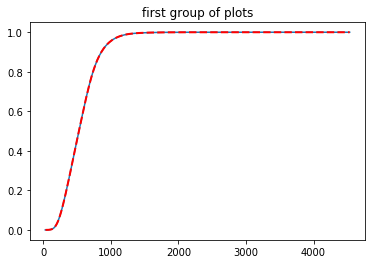

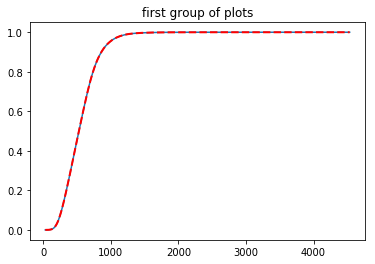

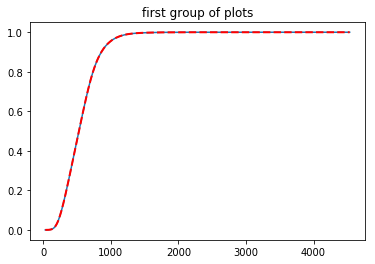

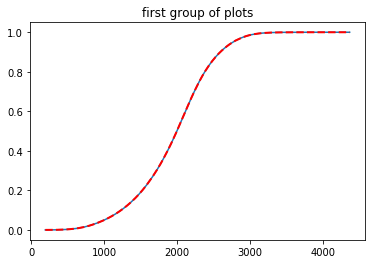

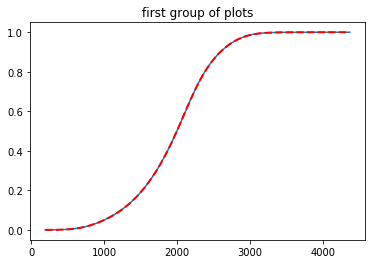

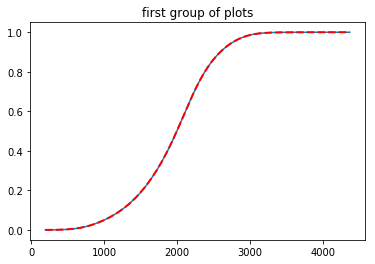

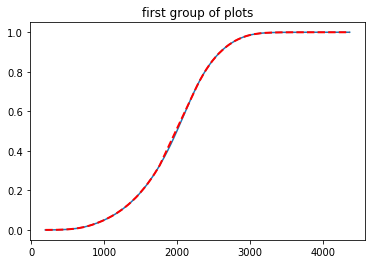

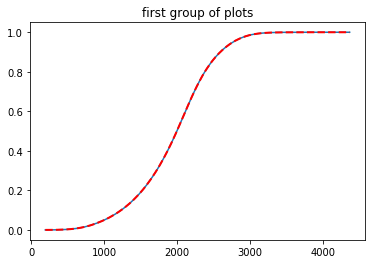

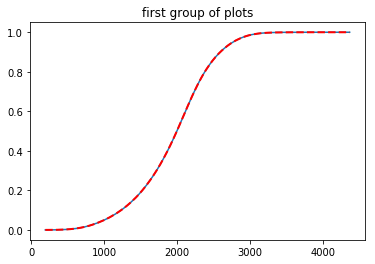

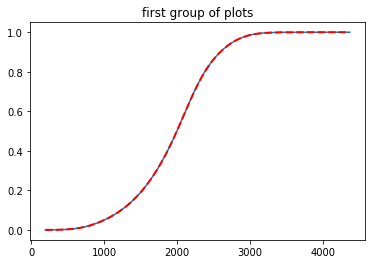

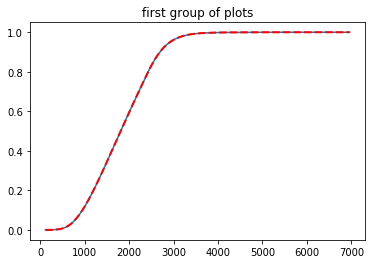

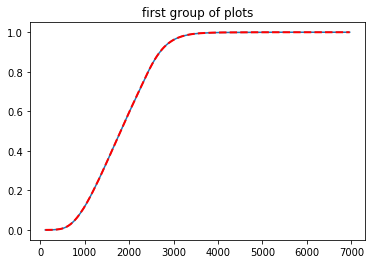

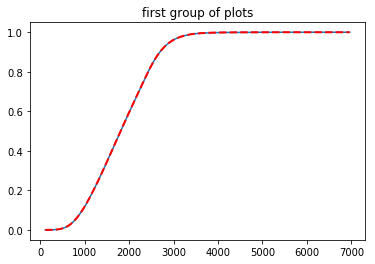

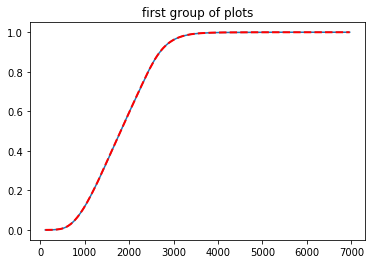

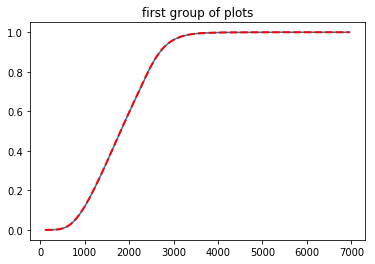

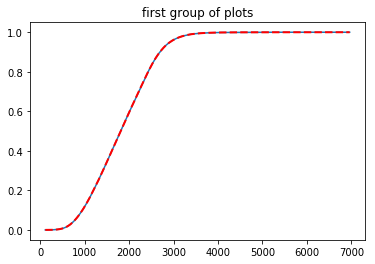

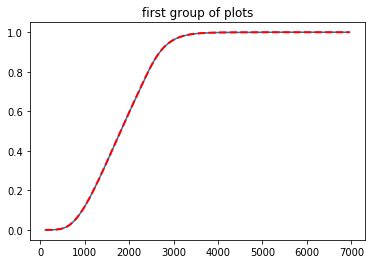

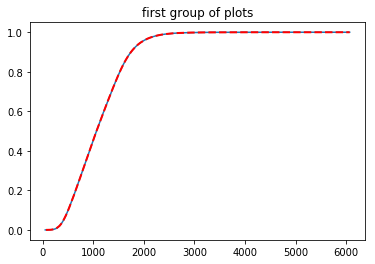

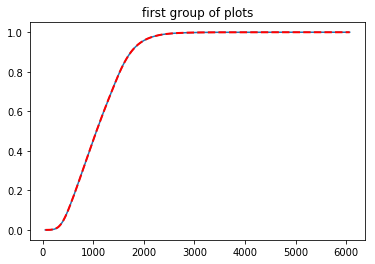

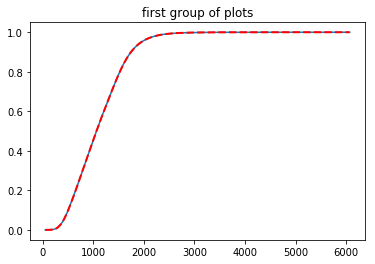

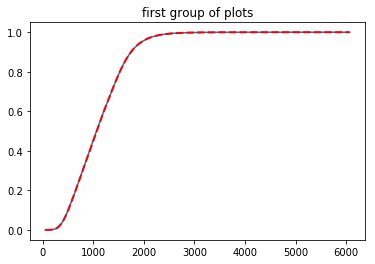

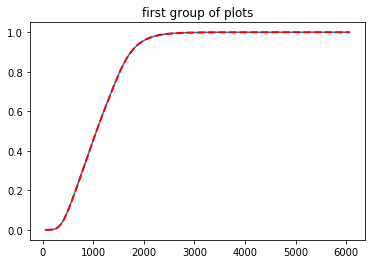

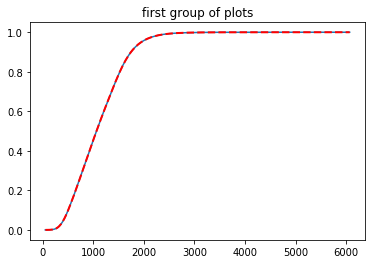

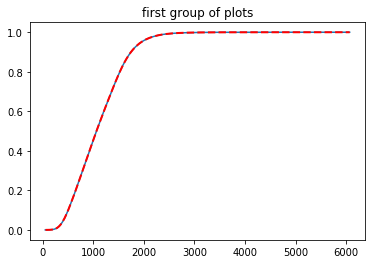

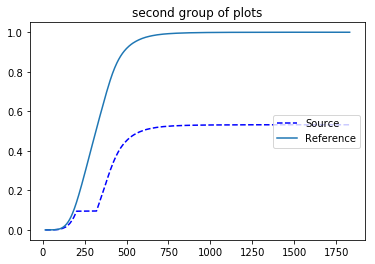

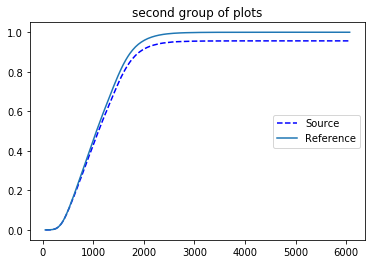

In [39]:
combined = fun(list_union_one_entry[0], center_dt, path, histogram_match=True)

In [40]:
combined.blue_mean

<xarray.DataArray 'blue_mean' (y: 1667, x: 1667)>
array([[  364,   320,   315, ...,   375,   333,   236],
       [  339,   336,   316, ...,   399,   311,   249],
       [  312,   340,   332, ...,   356,   321,   226],
       ...,
       [-9999, -9999, -9999, ...,   174,   177,   198],
       [-9999, -9999, -9999, ...,   196,   191,   179],
       [-9999, -9999, -9999, ...,   245,   198,   173]], dtype=int16)
Coordinates:
  * y        (y) float64 1.527e+06 1.526e+06 1.526e+06 ... 1.477e+06 1.477e+06
  * x        (x) float64 1.977e+06 1.977e+06 1.977e+06 ... 2.027e+06 2.027e+06

In [32]:
sr_test =  xr.auto_combine([GridWorkflow.load(x, dask_chunks={'x': 1200, 'y': 1200}) for x in list_union_one_entry[0][0][1]],
                            concat_dim='time')

In [33]:
sr_test

<xarray.Dataset>
Dimensions:   (time: 7, x: 1667, y: 1667)
Coordinates:
  * y         (y) float64 1.527e+06 1.526e+06 1.526e+06 ... 1.477e+06 1.477e+06
  * x         (x) float64 1.977e+06 1.977e+06 1.977e+06 ... 2.027e+06 2.027e+06
  * time      (time) datetime64[ns] 1995-02-06T16:46:48 ... 1996-11-23T16:56:17
Data variables:
    blue      (time, y, x) int16 dask.array<shape=(7, 1667, 1667), chunksize=(7, 1200, 1200)>
    green     (time, y, x) int16 dask.array<shape=(7, 1667, 1667), chunksize=(7, 1200, 1200)>
    red       (time, y, x) int16 dask.array<shape=(7, 1667, 1667), chunksize=(7, 1200, 1200)>
    nir       (time, y, x) int16 dask.array<shape=(7, 1667, 1667), chunksize=(7, 1200, 1200)>
    swir1     (time, y, x) int16 dask.array<shape=(7, 1667, 1667), chunksize=(7, 1200, 1200)>
    swir2     (time, y, x) int16 dask.array<shape=(7, 1667, 1667), chunksize=(7, 1200, 1200)>
    pixel_qa  (time, y, x) uint16 dask.array<shape=(7, 1667, 1667), chunksize=(7, 1200, 1200)>

In [34]:
sr_test.blue

<xarray.DataArray 'blue' (time: 7, y: 1667, x: 1667)>
dask.array<shape=(7, 1667, 1667), dtype=int16, chunksize=(7, 1200, 1200)>
Coordinates:
  * y        (y) float64 1.527e+06 1.526e+06 1.526e+06 ... 1.477e+06 1.477e+06
  * x        (x) float64 1.977e+06 1.977e+06 1.977e+06 ... 2.027e+06 2.027e+06
  * time     (time) datetime64[ns] 1995-02-06T16:46:48 ... 1996-11-23T16:56:17
Attributes:
    units:    reflectance
    nodata:   -9999
    crs:      PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",SPHEROID["WGS8...

In [36]:
sr_test.blue.attrs['nodata']

-9999

In [38]:
sr_test_blue_one_time_values = sr_test.blue.isel(time=0).values

In [39]:
sr_test_blue_one_time_values 

array([[  450,   368,   367, ...,   437,   359,   176],
       [  368,   368,   367, ...,   488,   307,   176],
       [  396,   422,   394, ...,   463,   332,   124],
       ...,
       [-9999, -9999, -9999, ...,   293,   319,   345],
       [-9999, -9999, -9999, ...,   345,   319,   345],
       [-9999, -9999, -9999, ...,   422,   345,   293]], dtype=int16)

In [44]:
sr_test_blue_one_time_values==-9999

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

# Usando client y map

In [ ]:
if len(list_iterable_reference_adjusted) == len(list_iterable_sorted):
    list_union = [(s,t) for (s,t) in zip(list_iterable_sorted, list_iterable_reference_adjusted)]
    C = client.map(fun, list_union,
                   pure=False,
                   **{'center_dt': center_dt,
                      'path': path,
                      'histogram_match': True}) 
else:
    logger.info('Can not perform histogram match, source and reference lists have different lengths')
    C = None


(Not finished)

# Just a few lines to help 

In [1]:
import xarray as xr
import numpy as np
from datetime import datetime
import datetime as dt
from xarray.testing import assert_identical

In [2]:
arr = np.array([1,2,-9999], dtype=np.int16)
date_list = [datetime(2018, 1, 1) + dt.timedelta(delta) for delta in range(3)]
xarr = xr.DataArray(arr, dims=['time'], coords={'time': date_list},
                    attrs={'nodata': -9999})
xset = xr.Dataset({'blue': xarr, 'green': xarr, 'red': xarr}, attrs = xarr.attrs)
print(xset)

<xarray.Dataset>
Dimensions:  (time: 3)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 2018-01-03
Data variables:
    blue     (time) int16 1 2 -9999
    green    (time) int16 1 2 -9999
    red      (time) int16 1 2 -9999
Attributes:
    nodata:   -9999


In [3]:
xset.attrs

OrderedDict([('nodata', -9999)])

In [4]:
from madmex.util.xarray import to_float, to_int

In [5]:
xset_float = xset.apply(func=to_float, keep_attrs=True)

In [6]:
xset_float

<xarray.Dataset>
Dimensions:  (time: 3)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 2018-01-03
Data variables:
    blue     (time) float64 1.0 2.0 nan
    green    (time) float64 1.0 2.0 nan
    red      (time) float64 1.0 2.0 nan
Attributes:
    nodata:   -9999

In [15]:
np.isnan(xset_float.blue.values)

array([False, False,  True])

In [7]:
xset_int = xset_float.apply(to_int)

In [8]:
xset_int

<xarray.Dataset>
Dimensions:  (time: 3)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 2018-01-03
Data variables:
    blue     (time) int16 1 2 -9999
    green    (time) int16 1 2 -9999
    red      (time) int16 1 2 -9999

In [9]:
assert_identical(xset, xset_int)

AssertionError: <xarray.Dataset>
Dimensions:  (time: 3)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 2018-01-03
Data variables:
    blue     (time) int16 1 2 -9999
    green    (time) int16 1 2 -9999
    red      (time) int16 1 2 -9999
Attributes:
    nodata:   -9999
<xarray.Dataset>
Dimensions:  (time: 3)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 2018-01-03
Data variables:
    blue     (time) int16 1 2 -9999
    green    (time) int16 1 2 -9999
    red      (time) int16 1 2 -9999

In [14]:
xset_float = xset.where(xset != xset.attrs['nodata'])

TypeError: where() got an unexpected keyword argument 'keep_attrs'

In [9]:
xset_float

<xarray.Dataset>
Dimensions:  (time: 3)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 2018-01-03
Data variables:
    blue     (time) float64 1.0 2.0 nan
    green    (time) float64 1.0 2.0 nan
    red      (time) float64 1.0 2.0 nan
Attributes:
    nodata:   -9999

In [11]:
from xarray import DataArray

In [13]:
xset_int = xset_float.where(DataArray.notnull(xset_float), xset_float.attrs['nodata'])

AttributeError: 'Dataset' object has no attribute '__array_wrap__'

In [ ]:
xset_int